In [3]:
import requests
import warnings
warnings.filterwarnings("ignore")
import numpy as np
import torch
import random
from pytorch_lightning import seed_everything
seed = 12
def set_seed(seed = int):
    '''Sets the seed of the entire notebook so results are the same every time we run.
    This is for REPRODUCIBILITY.'''
    np.random.seed(seed)
    random_state = np.random.RandomState(seed)
    random.seed(seed)
    torch.manual_seed(seed)
    torch.cuda.manual_seed(seed)
    torch.backends.cudnn.deterministic = True
    torch.backends.cudnn.benchmark = False
    os.environ['PYTHONHASHSEED'] = str(seed)
    seed_everything(seed)
    return random_state
random_state = set_seed(seed)

url = 'https://gist.githubusercontent.com/skywalker0803r/e0ef295d69aba240e6ff1537be354bc8/raw/eab83e022de41cfedf1644bd4e5752c97b2488f8/Modeling.py'
exec(requests.get(url).text)

Global seed set to 12


In [4]:
import joblib
data = joblib.load('data.pkl')
merged_df = data['merged_df']
input_col = data['input_col']
output_col = data['output_col']


In [5]:
sorted(merged_df.columns.tolist())[:10]

['ProductDSARRDS2',
 'ProductDSARRDS2.1',
 'ProductDSARRDS2.10',
 'ProductDSARRDS2.11',
 'ProductDSARRDS2.12',
 'ProductDSARRDS2.13',
 'ProductDSARRDS2.14',
 'ProductDSARRDS2.15',
 'ProductDSARRDS2.16',
 'ProductDSARRDS2.17']

In [6]:
url = 'https://gist.githubusercontent.com/skywalker0803r/c92f4651ccbd0640c2a8c97c017092d9/raw/adedbf1159e92402f32b8d961f6db70a1b0c95ad/DataPreprocessingArmory.py'
exec(requests.get(url).text)

In [7]:
x_col = set(merged_df.columns)&set(input_col)
y_col = set(merged_df.columns)&set(output_col)
len(x_col),len(y_col),len(input_col),len(output_col)

(113, 47, 113, 47)

In [8]:
x_col.issubset(input_col) ,y_col.issubset(output_col) 

(True, True)

In [9]:
train_loader,val_loader = df_2_torch_data_iter(df=merged_df,x_col=x_col,y_col=y_col,test_size=0.2,random_state=seed,batch_size=7)

In [10]:
model = build_mlp(
    layers = [len(x_col),128,128,len(y_col)],
    activation_function = nn.ReLU(),
    output_activation_function = nn.Sigmoid(),
    )
model

Sequential(
  (0): Linear(in_features=113, out_features=128, bias=True)
  (1): ReLU()
  (2): Linear(in_features=128, out_features=128, bias=True)
  (3): ReLU()
  (4): Linear(in_features=128, out_features=47, bias=True)
  (5): Sigmoid()
)

In [11]:
import torch
from tqdm import tqdm
from copy import deepcopy

def step(model,batch,optimizer,device,loss_fn,mode='train'):
    '''
    這個函數實現了模型前向&後向傳播的過程,稱之為step
    '''
    # model to device
    model = model.to(device)
    # change mode(train/val)
    if mode == 'train':
        model.train()
    if mode == 'val':
        model.eval()
    # model forward pass
    x,y = batch
    x = x.to(device)
    y = y.to(device)
    output = model(x)
    loss = loss_fn(y,output)
    # update model if mode == train
    if mode == 'train': 
        loss.backward()
        optimizer.step()
        optimizer.zero_grad()
    return loss.item()

def train_loop(model,train_loader,val_loader,optimizer,device,loss_fn,max_epochs=12):
    history = {'train_loss':[],'val_loss':[]}
    best_loss = np.inf
    best_model = None
    for epoch in tqdm(range(max_epochs)):        
        epoch_train_loss = 0.0
        epoch_val_loss = 0.0
        for i,batch in enumerate(train_loader):
            epoch_train_loss += step(model,batch,optimizer,device,loss_fn,mode='train')
        for j,batch in enumerate(val_loader):
            epoch_val_loss += step(model,batch,optimizer,device,loss_fn,mode='val')
        history['train_loss'].append(epoch_train_loss/(i+1))
        history['val_loss'].append(epoch_val_loss/(j+1))
        print(f'epoch:{epoch} train_loss:{epoch_train_loss/(i+1)} val_loss:{epoch_val_loss/(j+1)}')
        if history['val_loss'][-1] <= best_loss: 
            best_model = deepcopy(model.eval())
            best_loss = history['val_loss'][-1]
            print(f'save best_model now_val_best_loss is:{best_loss}')
    return best_model.eval() ,history

optimizer = torch.optim.Adam(
    params = model.parameters(),
    lr = 1e-3)
device = 'cpu'
loss_fn = nn.SmoothL1Loss()
best_model ,history = train_loop(model,train_loader,val_loader,optimizer,device,loss_fn,max_epochs=100)

 11%|█         | 11/100 [00:00<00:00, 103.93it/s]

epoch:0 train_loss:0.04145278409123421 val_loss:0.030799604952335358
save best_model now_val_best_loss is:0.030799604952335358
epoch:1 train_loss:0.038241032510995865 val_loss:0.028100846335291862
save best_model now_val_best_loss is:0.028100846335291862
epoch:2 train_loss:0.03500379342585802 val_loss:0.025557653978466988
save best_model now_val_best_loss is:0.025557653978466988
epoch:3 train_loss:0.03284205915406346 val_loss:0.024245481938123703
save best_model now_val_best_loss is:0.024245481938123703
epoch:4 train_loss:0.032100606709718704 val_loss:0.023345891386270523
save best_model now_val_best_loss is:0.023345891386270523
epoch:5 train_loss:0.031380795408040285 val_loss:0.022435765713453293
save best_model now_val_best_loss is:0.022435765713453293
epoch:6 train_loss:0.030621166806668043 val_loss:0.02193286269903183
save best_model now_val_best_loss is:0.02193286269903183
epoch:7 train_loss:0.030058351811021566 val_loss:0.02171279862523079
save best_model now_val_best_loss is:0.0

 37%|███▋      | 37/100 [00:00<00:00, 112.90it/s]

epoch:22 train_loss:0.01582162664271891 val_loss:0.015565711073577404
epoch:23 train_loss:0.015535453101620078 val_loss:0.01546704676002264
save best_model now_val_best_loss is:0.01546704676002264
epoch:24 train_loss:0.015264967922121286 val_loss:0.015412543900310993
save best_model now_val_best_loss is:0.015412543900310993
epoch:25 train_loss:0.01503747096285224 val_loss:0.015358942560851574
save best_model now_val_best_loss is:0.015358942560851574
epoch:26 train_loss:0.014797249110415578 val_loss:0.015319892205297947
save best_model now_val_best_loss is:0.015319892205297947
epoch:27 train_loss:0.014571589417755604 val_loss:0.015313807874917984
save best_model now_val_best_loss is:0.015313807874917984
epoch:28 train_loss:0.014366664690896869 val_loss:0.015318880788981915
epoch:29 train_loss:0.01416860707104206 val_loss:0.015323334373533726
epoch:30 train_loss:0.013974542496725917 val_loss:0.015328407287597656
epoch:31 train_loss:0.013814534060657024 val_loss:0.015343754552304745
epoch

 65%|██████▌   | 65/100 [00:00<00:00, 122.68it/s]

epoch:47 train_loss:0.011816737707704306 val_loss:0.015354331582784653
epoch:48 train_loss:0.011671835323795676 val_loss:0.015339632518589497
epoch:49 train_loss:0.011569203110411763 val_loss:0.01533227413892746
epoch:50 train_loss:0.011432273546233773 val_loss:0.015279480256140232
save best_model now_val_best_loss is:0.015279480256140232
epoch:51 train_loss:0.011295677861198783 val_loss:0.015262393280863762
save best_model now_val_best_loss is:0.015262393280863762
epoch:52 train_loss:0.011194052174687386 val_loss:0.015249162912368774
save best_model now_val_best_loss is:0.015249162912368774
epoch:53 train_loss:0.01104772777762264 val_loss:0.015264458954334259
epoch:54 train_loss:0.01095692627131939 val_loss:0.015272743068635464
epoch:55 train_loss:0.010799248004332185 val_loss:0.015270103700459003
epoch:56 train_loss:0.010674659162759781 val_loss:0.015185793861746788
save best_model now_val_best_loss is:0.015185793861746788
epoch:57 train_loss:0.010558933834545314 val_loss:0.015227476

 92%|█████████▏| 92/100 [00:00<00:00, 118.53it/s]

epoch:72 train_loss:0.009320599143393338 val_loss:0.014947737567126751
save best_model now_val_best_loss is:0.014947737567126751
epoch:73 train_loss:0.009692742605693638 val_loss:0.014984042383730412
epoch:74 train_loss:0.009074431378394365 val_loss:0.014792927540838718
save best_model now_val_best_loss is:0.014792927540838718
epoch:75 train_loss:0.009127187309786677 val_loss:0.014745475724339485
save best_model now_val_best_loss is:0.014745475724339485
epoch:76 train_loss:0.008553283871151507 val_loss:0.01476109866052866
epoch:77 train_loss:0.008580669644288719 val_loss:0.014699511229991913
save best_model now_val_best_loss is:0.014699511229991913
epoch:78 train_loss:0.008262059069238603 val_loss:0.014815554022789001
epoch:79 train_loss:0.008215271518565714 val_loss:0.014681686647236347
save best_model now_val_best_loss is:0.014681686647236347
epoch:80 train_loss:0.008039117674343288 val_loss:0.014715856872498989
epoch:81 train_loss:0.00796918966807425 val_loss:0.014688762836158276
ep

100%|██████████| 100/100 [00:00<00:00, 124.55it/s]

epoch:94 train_loss:0.007287245825864375 val_loss:0.014793182723224163
epoch:95 train_loss:0.007529106107540429 val_loss:0.015213736332952976
epoch:96 train_loss:0.00743637653067708 val_loss:0.014879278838634491
epoch:97 train_loss:0.007818535610567778 val_loss:0.015139290131628513
epoch:98 train_loss:0.007603067089803517 val_loss:0.014977914281189442
epoch:99 train_loss:0.007843206461984664 val_loss:0.014982815831899643


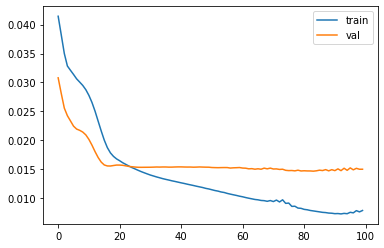

In [12]:
import matplotlib.pyplot as plt
plt.plot(history['train_loss'],label='train')
plt.plot(history['val_loss'],label='val')
plt.legend()
plt.show()

In [13]:
from sklearn.metrics import r2_score,mean_squared_error
from numpy import sqrt

def mape(a, b): 
    mask = a != 0
    return (np.fabs(a - b)/a)[mask].mean()

y_pred = model(torch.FloatTensor(merged_df[x_col].values))
y_real = torch.FloatTensor(merged_df[y_col].values)
print('r2:',r2_score(y_real.detach().numpy(),y_pred.detach().numpy()))
print('rmse:',sqrt(mean_squared_error(y_real.detach().numpy(),y_pred.detach().numpy())))
print('mape:',mape(y_real.detach().numpy(),y_pred.detach().numpy()))

r2: 0.6720316027765129
rmse: 0.13042548
mape: 0.37876296
